In [1]:
!pip install deep_hedging

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:00
  Created wheel for deep_hedging: filename=deep_hedging-1.11-py3-none-any.whl size=76991 sha256=579a3de1a44cfc29992b57d91ec573d7d9e67df31c483cb356a3e73d998bd736
  Stored in directory: /root/.cache/pip/wheels/2e/73/ec/eb9c7dd22320145f9ec4f9275967356730677b4fe6e03ebc13
Successfully built deep_hedging


In [2]:
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from deep_hedging import (
    Underlyings,
    Ticker,
    ConstantRateCurve,
    EuropeanCall,
)
from deep_hedging import Hedger
from deep_hedging.monte_carlo import GBMSimulator

RANDOM_SEED = 12

In [3]:
N_PATHS = 200_000
N_STOCKS = 1
TILL_MATURITY = 3.0
N_DAYS = 365 * TILL_MATURITY
RF_RATE = 0.03
STRIKE_LEVEL = 1.0
VOL = 0.2

In [4]:
np.random.seed(RANDOM_SEED)

start = dt.datetime(2019, 1, 1)
end = start + dt.timedelta(days=N_DAYS)

underlyings = Underlyings(
    tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
    start=start,
    end=end,
    dividends=np.array([0.0] * N_STOCKS),
    means=np.array([RF_RATE] * N_STOCKS),
    var_covar=np.array([VOL**2] * N_STOCKS),
)
underlyings.data

In [5]:
curve = ConstantRateCurve(constant_rate=RF_RATE)

In [6]:
european_call = EuropeanCall(
    underlyings=underlyings,
    yield_curve=curve,
    strike_level=STRIKE_LEVEL,
    start_date=start,
    end_date=end,
)

In [7]:
pricer = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)

In [8]:
paths = pricer.get_paths(
    spot=[1.0],
    time_till_maturity=TILL_MATURITY,
    risk_free_rate_fn=curve.get_instant_fwd_rate,
    dividends_fn=lambda t: 0.0,
    var_covar_fn=lambda t: np.array([VOL**2] * len(t)),
    n_paths=N_PATHS,
).squeeze(2)
paths.shape

(200000, 757)

In [9]:
hedger = Hedger(european_call, look_ahead=True)

In [10]:
pnl_hedge, interest, pnl_opt = hedger.simulate(
    bids=paths,
    asks=paths,
    rates_lend=curve(european_call.days_till_maturity) / 365,
    rates_borrow=curve(european_call.days_till_maturity) / 365,
)
pnl_hedge.mean(), pnl_opt.mean()

(0.06239734272167672, 0.19546460231066645)

In [11]:
RF_RATE * european_call.time_till_maturity

0.09

In [12]:
((pnl_opt - pnl_hedge).mean() + np.exp(RF_RATE * european_call.time_till_maturity) - 1) * np.exp(-RF_RATE * european_call.time_till_maturity)

0.2076831330057314

In [13]:
(np.ones(paths.shape) * european_call.delta()).shape

(200000, 757)

In [14]:
paths.shape

(200000, 757)

In [15]:
pnl_opt.std(), pnl_hedge.std(), (pnl_hedge - pnl_opt).std()

(0.3012065987458439, 0.3152928014361705, 0.0210928278115045)

In [16]:
X = ((pnl_opt - pnl_hedge).mean() + RF_RATE * european_call.time_till_maturity) * np.exp(-RF_RATE * european_call.time_till_maturity)
X

0.20386812495137013

In [17]:
european_call.price()

array([[0.17899527]])

In [18]:
np.corrcoef(pnl_hedge, pnl_opt)

array([[1.        , 0.99870227],
       [0.99870227, 1.        ]])

In [19]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).mean()

-0.0003874233295861332

In [20]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.3012065987458439

In [21]:
(
    pnl_opt
    - pnl_hedge
    - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.021092827811504504

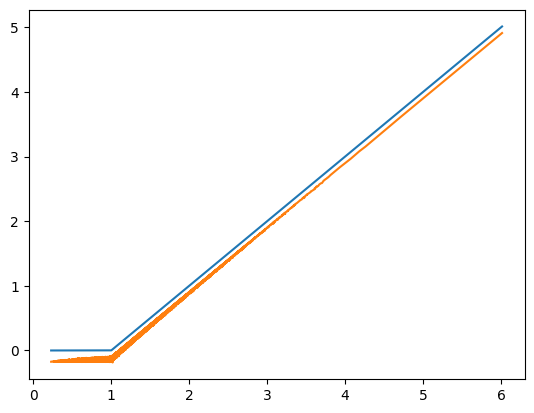

In [22]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

In [23]:
(pnl_hedge - RF_RATE * european_call.time_till_maturity).mean()

-0.027602657278323266

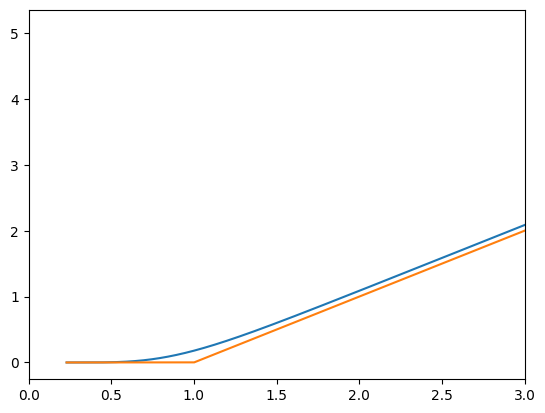

In [24]:
value_opt = european_call.price(spot=paths[:, -1])

plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.xlim([0, 3])
plt.show()

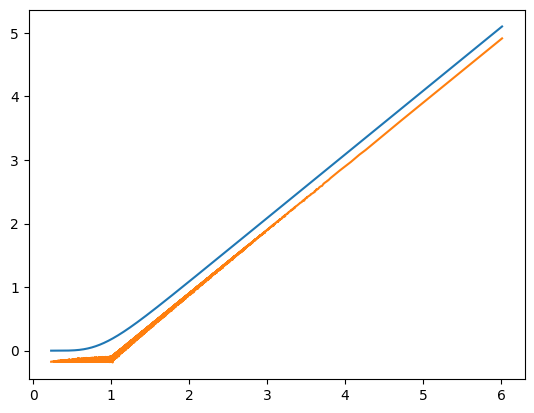

In [25]:
plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

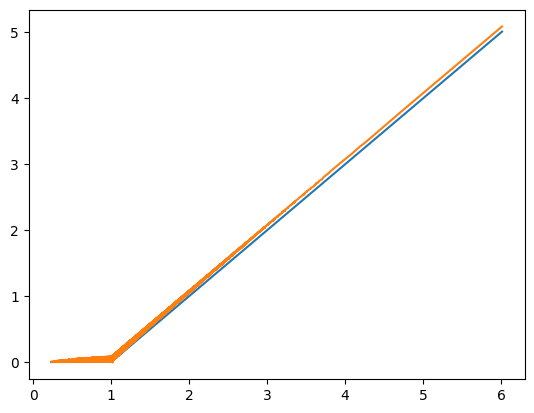

In [26]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(
    np.sort(paths[:, -1]),
    pnl_hedge[np.argsort(paths[:, -1])] + european_call.price().T.squeeze(1),
)
plt.show()

In [27]:
portfolio = pnl_hedge + european_call.price().T.squeeze(1) * np.exp(RF_RATE * european_call.time_till_maturity) - pnl_opt
portfolio.mean(), portfolio.std()

(0.06278476605126286, 0.021092827811504497)

In [28]:
european_call.delta()

array([[0.66749723]])

In [29]:
0.6 * RF_RATE * european_call.time_till_maturity

0.05399999999999999